In [3]:
import os
import numpy as np
import pandas as pd
from collections import deque

!pip install music21
!pip install pygame

from music21 import converter, instrument, note, chord, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.
Using TensorFlow backend.


In [4]:
# grab / parse data

In [5]:
directory = "midi/Piano"
# specify the number of track in each song (should be the same, in same order, for each song)
tracks = (0,)
instru = instrument.Piano()

notes = [[] for track in tracks]
durations = [[] for track in tracks]
offsets = [[] for track in tracks]
velocities = [[] for track in tracks]
for i, file in enumerate(os.listdir(directory)):
    midi_part = converter.parse(os.path.join(directory, file))
    # Parse the midi file by the notes/chords it contains
    for track, _ in enumerate(tracks):
        notes_to_parse = midi_part[tracks[track]].flat.notesAndRests
        notes_to_parse = notes_to_parse.makeMeasures()
        for meas in notes_to_parse.measures(0, None):
            if isinstance(meas, stream.Measure):
                meas = meas.chordify()
                notes_meas_tab = []
                durations_meas_tab = []
                offsets_meas_tab = []
                velocities_meas_tab = []
                for elem in meas:    
                    if isinstance(elem, note.Note):
                        notes_meas_tab.append([str(elem.pitch)])
                        durations_meas_tab.append(elem.quarterLength)
                        offsets_meas_tab.append(elem.offset)
                        velocities_meas_tab.append(elem.volume.velocity)
                    elif isinstance(elem, chord.Chord):
                        notes_meas_tab.append([str(n.nameWithOctave) for n in elem.pitches])
                        durations_meas_tab.append(elem.quarterLength)
                        offsets_meas_tab.append(elem.offset)
                        velocities_meas_tab.append(elem.volume.velocity)
                    elif isinstance(elem, note.Rest):
                        notes_meas_tab.append([elem.name])
                        durations_meas_tab.append(elem.quarterLength)
                        offsets_meas_tab.append(elem.offset)
                        velocities_meas_tab.append(0)
                notes[track].append(notes_meas_tab)
                durations[track].append(durations_meas_tab)
                offsets[track].append(offsets_meas_tab)
                velocities[track].append(velocities_meas_tab)
    print("Song %s Loaded" % file)
print("DONE LOADING SONGS") 
# Get all notes
np_notes = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in notes[track]:
        np_notes[track] += elem
np_notes = [np.array(np_notes[track]) for track in tracks]
np_notes = [np_notes[track].flatten() for track in tracks]
notes_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for item in np_notes[track]:
        if len(item) > 1 and item != "rest":
            notes_vocab[track].append(",".join([note for note in item]))
        else:
            notes_vocab[track].append(item[0])
    notes_vocab[track] = sorted(set(notes_vocab[track]))
# Get all durations
np_durations = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in durations[track]:
        np_durations[track] += elem
durations_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    durations_vocab[track] = sorted(set(np.array(np_durations[track]).flatten()))
# Get all offsets
np_offsets = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in offsets[track]:
        np_offsets[track] += elem
offsets_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    offsets_vocab[track] = sorted(set(np.array(np_offsets[track]).flatten()))
# get all velocities
np_velocities = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in velocities[track]:
        np_velocities[track] += elem
velocities_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    velocities_vocab[track] = sorted(set(np.array(np_velocities[track]).flatten()))
    
for track, _ in enumerate(tracks):
    print("%s Measures, notes_Vocab : %s ; durations_Vocab : %s" % (len(notes[track]), len(notes_vocab[track]), len(durations_vocab[track])))
print(notes_vocab, notes)
print(durations_vocab, durations)

Song br_im2_format0.mid Loaded
Song br_im5_format0.mid Loaded
Song br_im6_format0.mid Loaded
Song br_rhap_format0.mid Loaded
Song chpn_op7_1_format0.mid Loaded
Song chpn_op7_2_format0.mid Loaded
Song chp_op18_format0.mid Loaded
Song chp_op31_format0.mid Loaded
Song Etude op10 n01.mid Loaded
Song Etude op10 n02.mid Loaded
Song Etude op10 n10.mid Loaded
Song jsb2pin1.mid Loaded
Song jsb2pin4.mid Loaded
Song jsb2pin8.mid Loaded
DONE LOADING SONGS
1283 Measures, notes_Vocab : 3520 ; durations_Vocab : 73
[['A1', 'A1,A2', 'A1,A2,A4', 'A1,A2,A4,C5,A5', 'A1,A2,A5,D6,F6', 'A1,A2,B-5', 'A1,A2,B5', 'A1,A2,C#4', 'A1,A2,C#4,A4', 'A1,A2,C#7', 'A1,A2,C4,G#4,B4', 'A1,A2,C5', 'A1,A2,C5,E5,A5', 'A1,A2,C6', 'A1,A2,C6,E6,A6', 'A1,A2,D5,F5,A5', 'A1,A2,D6', 'A1,A2,E-6', 'A1,A2,E3,C#4,E4', 'A1,A2,E4', 'A1,A2,E5,A5,C#6', 'A1,A2,E6', 'A1,A2,F#5', 'A1,A2,F#6', 'A1,A2,F4', 'A1,A2,F5,A5,C#6', 'A1,A2,G#5', 'A1,A2,G#6', 'A1,A2,G4', 'A1,A2,G5', 'A1,A2,G6', 'A1,A3', 'A1,A3,C#4,A4', 'A1,A3,F#4', 'A1,A4', 'A1,A4,A5', '

In [6]:
maxLen = 0
for track, _ in enumerate(tracks):
    currMax = max(len(elem) for elem in notes[track])
    if currMax > maxLen:
        maxLen = currMax
for track, _ in enumerate(tracks):
    currMax = max(len(elem) for elem in durations[track])
    if currMax > maxLen:
        maxLen = currMax
for track, _ in enumerate(tracks):
    currMax = max(len(elem) for elem in offsets[track])
    if currMax > maxLen:
        maxLen = currMax
for track, _ in enumerate(tracks):
    currMax = max(len(elem) for elem in velocities[track])
    if currMax > maxLen:
        maxLen = currMax
        
print(maxLen)

31


In [9]:
cat_notes = [[] for track in tracks]
cat_durations = [[] for track in tracks]
cat_offsets = [[] for track in tracks]
cat_velocities = [[] for track in tracks]

for track, _ in enumerate(tracks):
    for mes in notes[track]:
        cat_tab = []
        for elem in mes:
            int_note = notes_vocab[track].index(",".join(elem))
            cat = np.zeros((len(notes_vocab[track])))
            cat[int_note] = 1
            cat_tab.append(cat)
        cat_notes[track].append(cat_tab)
    cat_notes[track] = pad_sequences(cat_notes[track], maxlen=maxLen)
    for mes in durations[track]:
        cat_tab = []
        for elem in mes:
            int_duration = durations_vocab[track].index(elem)
            cat = np.zeros((len(durations_vocab[track])))
            cat[int_duration] = 1
            cat_tab.append(cat)
        cat_durations[track].append(cat_tab)
    cat_durations[track] = pad_sequences(cat_durations[track], maxlen=maxLen)
    for mes in offsets[track]:
        cat_tab = []
        for elem in mes:
            int_offset = offsets_vocab[track].index(elem)
            cat = np.zeros((len(offsets_vocab[track])))
            cat[int_offset] = 1
            cat_tab.append(cat)
        cat_offsets[track].append(cat_tab)
    cat_offsets[track] = pad_sequences(cat_offsets[track], maxlen=maxLen)
    for mes in velocities[track]:
        cat_tab = []
        for elem in mes:
            int_velocity = velocities_vocab[track].index(elem)
            cat = np.zeros((len(velocities_vocab[track])))
            cat[int_velocity] = 1
            cat_tab.append(cat)
        cat_velocities[track].append(cat_tab)
    cat_velocities[track] = pad_sequences(cat_velocities[track], maxlen=maxLen)
# merge
x = [cat_notes, cat_durations, cat_offsets, cat_velocities]

In [134]:
# Build generator

In [14]:
#seq_len = 1
batch_size = 32
#split = int(0.8 * len(x))

class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
    def __len__(self):
        return len(self.x[0][0]) // self.batch_size - 1
    def __getitem__(self, idx):
        
        X_note = [[] for track in tracks]
        X_duration = [[] for track in tracks]
        X_offset = [[] for track in tracks]
        X_velocity = [[] for track in tracks]
        
        Y_note = [[] for track in tracks]
        Y_duration = [[] for track in tracks]
        Y_offset = [[] for track in tracks]
        Y_velocity = [[] for track in tracks]
        
        res = [[], []]
        for track, _ in enumerate(tracks):
            for i in range(self.batch_size):
                
                X_note[track].append(self.x[0][track][idx+i ])#: idx+i + seq_len])
                X_duration[track].append(self.x[1][track][idx+i ])#: idx+i + seq_len])
                X_offset[track].append(self.x[2][track][idx+i ])#: idx+i + seq_len])
                X_velocity[track].append(self.x[3][track][idx+i ])#: idx+i + seq_len])
                
                Y_note[track].append(self.x[0][track][idx+i + 1])#seq_len])
                Y_duration[track].append(self.x[1][track][idx+i + 1])#seq_len])
                Y_offset[track].append(self.x[2][track][idx+i + 1])#seq_len])
                Y_velocity[track].append(self.x[3][track][idx+i + 1])#seq_len])
            
            X_note[track] = np.array(X_note[track])
            X_duration[track] = np.array(X_duration[track])
            X_offset[track] = np.array(X_offset[track])
            X_velocity[track] = np.array(X_velocity[track])
            
            Y_note[track] = np.array(Y_note[track])
            Y_duration[track] = np.array(Y_duration[track])
            Y_offset[track] = np.array(Y_offset[track])
            Y_velocity[track] = np.array(Y_velocity[track])
            
            res[0].append(X_note[track])
            res[0].append(X_duration[track])
            res[0].append(X_offset[track])
            res[0].append(X_velocity[track])
            
            res[1].append(Y_note[track])
            res[1].append(Y_duration[track])
            res[1].append(Y_offset[track])
            res[1].append(Y_velocity[track])
            
        return res
data_gen = dataGenerator(x, batch_size)

In [15]:
data_gen[0][0][0].shape

(32, 31, 3520)

In [137]:
# Build Model

In [16]:
K.clear_session()

inputs_list = []
tracks_list = []
outputs_list = []

for track, _ in enumerate(tracks):
    
    in_note = Input(shape=(maxLen, len(notes_vocab[track])))
    inputs_list.append(in_note)
    x1 = Masking(mask_value=0.0)(in_note)
    x1 = LSTM(64, return_sequences=True)(x1)
    x1 = LSTM(32, return_sequences=True)(x1)
    tracks_list.append(x1)
    
    in_duration = Input(shape=(maxLen, len(durations_vocab[track])))
    inputs_list.append(in_duration)
    x2 = Masking(mask_value=0.0)(in_duration)
    x2 = LSTM(64, return_sequences=True)(x2)
    x2 = LSTM(32, return_sequences=True)(x2)
    tracks_list.append(x2)
    
    in_offset = Input(shape=(maxLen, len(offsets_vocab[track])))
    inputs_list.append(in_offset)
    x3 = Masking(mask_value=0.0)(in_offset)
    x3 = LSTM(64, return_sequences=True)(x3)
    x3 = LSTM(32, return_sequences=True)(x3)
    tracks_list.append(x3)
    
    in_velocity = Input(shape=(maxLen, len(velocities_vocab[track])))
    inputs_list.append(in_velocity)
    x4 = Masking(mask_value=0.0)(in_velocity)
    x4 = LSTM(64, return_sequences=True)(x4)
    x4 = LSTM(32, return_sequences=True)(x4)
    tracks_list.append(x4)

concat = Concatenate()(tracks_list)
shared = TimeDistributed(Dense(64, activation='relu'))(concat)

for track, _ in enumerate(tracks):
    out_note = Dense(len(notes_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_note)
    
    out_duration = Dense(len(durations_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_duration)
    
    out_offset = Dense(len(offsets_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_offset)
    
    out_velocity = Dense(len(velocities_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_velocity)

model = Model(inputs=inputs_list, 
              outputs=outputs_list)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['acc'])

model.summary()

W0804 15:47:54.948381 10268 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0804 15:47:54.949377 10268 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 15:47:54.973316 10268 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 15:47:54.974313 10268 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:51

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 31, 3520)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 31, 73)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 31, 62)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 31, 102)      0                                            
__________________________________________________________________________________________________
masking_1 

In [17]:
#save best model if model improved
model_name = "Piano_measured.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join("weight_save", model_name), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [18]:
h = model.fit_generator(data_gen, epochs = 100)

Epoch 1/100
39/39 [==============================] - 18s 459ms/step - loss: 16.0921 - dense_2_loss: 6.6082 - dense_3_loss: 2.7062 - dense_4_loss: 3.1410 - dense_5_loss: 3.6367 - dense_2_acc: 0.0239 - dense_3_acc: 0.2390 - dense_4_acc: 0.0829 - dense_5_acc: 0.0344
Epoch 2/100
39/39 [==============================] - 13s 333ms/step - loss: 12.4810 - dense_2_loss: 5.0089 - dense_3_loss: 1.7057 - dense_4_loss: 2.6392 - dense_5_loss: 3.1272 - dense_2_acc: 0.0464 - dense_3_acc: 0.2833 - dense_4_acc: 0.0922 - dense_5_acc: 0.0903
Epoch 3/100
39/39 [==============================] - 13s 341ms/step - loss: 11.4680 - dense_2_loss: 4.4949 - dense_3_loss: 1.4624 - dense_4_loss: 2.4518 - dense_5_loss: 3.0590 - dense_2_acc: 0.0565 - dense_3_acc: 0.3436 - dense_4_acc: 0.1335 - dense_5_acc: 0.0924
Epoch 4/100
39/39 [==============================] - 13s 345ms/step - loss: 10.8471 - dense_2_loss: 4.1594 - dense_3_loss: 1.3786 - dense_4_loss: 2.3144 - dense_5_loss: 2.9947 - dense_2_acc: 0.0607 - dense_3_

39/39 [==============================] - 16s 406ms/step - loss: 1.3759 - dense_2_loss: 0.3034 - dense_3_loss: 0.2505 - dense_4_loss: 0.4075 - dense_5_loss: 0.4146 - dense_2_acc: 0.8230 - dense_3_acc: 0.7862 - dense_4_acc: 0.8875 - dense_5_acc: 0.7906
Epoch 33/100
39/39 [==============================] - 15s 394ms/step - loss: 1.2690 - dense_2_loss: 0.2789 - dense_3_loss: 0.2354 - dense_4_loss: 0.3674 - dense_5_loss: 0.3873 - dense_2_acc: 0.8261 - dense_3_acc: 0.7929 - dense_4_acc: 0.9048 - dense_5_acc: 0.7991
Epoch 34/100
39/39 [==============================] - 14s 360ms/step - loss: 1.1927 - dense_2_loss: 0.2596 - dense_3_loss: 0.2244 - dense_4_loss: 0.3469 - dense_5_loss: 0.3618 - dense_2_acc: 0.8334 - dense_3_acc: 0.7982 - dense_4_acc: 0.9150 - dense_5_acc: 0.8129
Epoch 35/100
39/39 [==============================] - 15s 373ms/step - loss: 1.1592 - dense_2_loss: 0.2521 - dense_3_loss: 0.2182 - dense_4_loss: 0.3390 - dense_5_loss: 0.3498 - dense_2_acc: 0.8242 - dense_3_acc: 0.7988 -

39/39 [==============================] - 14s 353ms/step - loss: 0.3153 - dense_2_loss: 0.0715 - dense_3_loss: 0.0673 - dense_4_loss: 0.0885 - dense_5_loss: 0.0880 - dense_2_acc: 0.8492 - dense_3_acc: 0.8494 - dense_4_acc: 0.9694 - dense_5_acc: 0.8704
Epoch 64/100
39/39 [==============================] - 14s 358ms/step - loss: 0.3274 - dense_2_loss: 0.0753 - dense_3_loss: 0.0668 - dense_4_loss: 0.0939 - dense_5_loss: 0.0914 - dense_2_acc: 0.8483 - dense_3_acc: 0.8491 - dense_4_acc: 0.9675 - dense_5_acc: 0.8698
Epoch 65/100
39/39 [==============================] - 14s 360ms/step - loss: 0.3039 - dense_2_loss: 0.0693 - dense_3_loss: 0.0650 - dense_4_loss: 0.0853 - dense_5_loss: 0.0843 - dense_2_acc: 0.8487 - dense_3_acc: 0.8482 - dense_4_acc: 0.9686 - dense_5_acc: 0.8711
Epoch 66/100
39/39 [==============================] - 15s 382ms/step - loss: 0.2961 - dense_2_loss: 0.0674 - dense_3_loss: 0.0631 - dense_4_loss: 0.0841 - dense_5_loss: 0.0815 - dense_2_acc: 0.8489 - dense_3_acc: 0.8490 -

39/39 [==============================] - 21s 546ms/step - loss: 0.1955 - dense_2_loss: 0.0511 - dense_3_loss: 0.0409 - dense_4_loss: 0.0533 - dense_5_loss: 0.0501 - dense_2_acc: 0.8492 - dense_3_acc: 0.8506 - dense_4_acc: 0.9707 - dense_5_acc: 0.8702
Epoch 95/100
39/39 [==============================] - 27s 690ms/step - loss: 0.1958 - dense_2_loss: 0.0518 - dense_3_loss: 0.0400 - dense_4_loss: 0.0531 - dense_5_loss: 0.0509 - dense_2_acc: 0.8492 - dense_3_acc: 0.8515 - dense_4_acc: 0.9711 - dense_5_acc: 0.8706
Epoch 96/100
39/39 [==============================] - 24s 607ms/step - loss: 0.1944 - dense_2_loss: 0.0517 - dense_3_loss: 0.0399 - dense_4_loss: 0.0534 - dense_5_loss: 0.0495 - dense_2_acc: 0.8495 - dense_3_acc: 0.8518 - dense_4_acc: 0.9707 - dense_5_acc: 0.8713
Epoch 97/100
39/39 [==============================] - 22s 557ms/step - loss: 0.1975 - dense_2_loss: 0.0507 - dense_3_loss: 0.0449 - dense_4_loss: 0.0531 - dense_5_loss: 0.0488 - dense_2_acc: 0.8496 - dense_3_acc: 0.8499 -

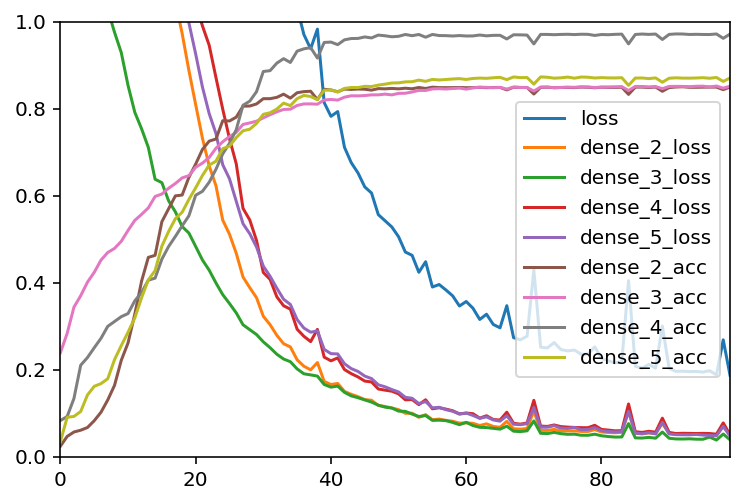

In [19]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [20]:
# Load / save

In [21]:
model.save(os.path.join("weight_save", model_name))
#model = load_model(os.path.join("weight_save", model_name))

In [144]:
# Test

In [33]:
# Build seed
idx = 627
x_test, _ = data_gen[idx]
x_test = [x_test[i][0] for i in range(len(x_test))]
x_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(maxLen):
        if 1 in x_test[2*track][i]:
            str_note = notes_vocab[track][np.argmax(x_test[4*track][i])]
            _duration = durations_vocab[track][np.argmax(x_test[4*track+1][i])]
            _offset = offsets_vocab[track][np.argmax(x_test[4*track+2][i])]
            _velocity = velocities_vocab[track][np.argmax(x_test[4*track+3][i])]
            if len(str_note.split(",")) > 1:
                _chord = chord.Chord(str_note.split(","))
                _chord.quarterLength = _duration
                _chord.offset = _offset
                _chord.volume.velocity = _velocity
                x_test_stream[track].append(_chord)
            else:
                if str_note != "rest":
                    _note = note.Note(str_note)
                    _note.quarterLength = _duration
                    _note.offset = _offset
                    _note.volume.velocity = _velocity
                    x_test_stream[track].append(_note)
                else:
                    _rest = note.Rest()
                    _rest.quarterLength = _duration
                    _rest.offset = _offset
                    x_test_stream[track].append(_rest)
    x_test_stream[track].insert(0, instru)

In [34]:
# make prediction from seed
x = x_test
pred = [[] for track in tracks]
preds = [[] for track in tracks]

for track, _ in enumerate(tracks):
    for mes in range(4):        
        pred[track] = model.predict([np.array([x[i]]) for i in range(len(x))])
        x = [pred[track][i][0] for i in range(len(pred[track]))]
        preds[track].append(pred[track])


In [35]:
# Build predicted stream
y_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for j in range(len(preds[track])):
        for i in range(maxLen):
            if 1 in x_test[2*track][i]:
                str_note = notes_vocab[track][np.argmax(preds[track][j][0][0][i])]
                _duration = durations_vocab[track][np.argmax(preds[track][j][1][0][i])]
                _offset = offsets_vocab[track][np.argmax(preds[track][j][2][0][i])]
                _velocity = velocities_vocab[track][np.argmax(preds[track][j][3][0][i])]
                if len(str_note.split(",")) > 1:
                    _chord = chord.Chord(str_note.split(","))
                    _chord.quarterLength = _duration
                    _chord.offset = _offset
                    _chord.volume.velocity = _velocity
                    y_test_stream[track].append(_chord)
                else:
                    if str_note != "rest":
                        _note = note.Note(str_note)
                        _note.quarterLength = _duration
                        _note.offset = _offset
                        _note.volume.velocity = _velocity
                        y_test_stream[track].append(_note)
                    else:
                        _rest = note.Rest()
                        _rest.quarterLength = _duration
                        _rest.offset = _offset
                        y_test_stream[track].append(_rest)
    y_test_stream[track].insert(0, instru)

In [36]:
# play seed
x_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(x_test_stream[track])
    x_full_score.insert(0, p)
x_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_full_score)
sp.play()

In [37]:
# play generated music
y_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(y_test_stream[track])
    y_full_score.insert(0, p)
y_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(y_full_score)
sp.play()